In [2]:
%load_ext autoreload
%autoreload
import inlp_dataset_handler
import inlp
import inlp_linear_model
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import LinearSVC, SVR
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import cluster
from sklearn.cluster import KMeans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Classification

In [ ]:
x_train, x_dev = np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5
y_train, y_dev = np.sum(x_train, axis = 1) > 0, np.sum(x_dev, axis = 1) > 0

inlp_dataset = inlp_dataset_handler.ClassificationDatasetHandler(x_train, y_train, x_dev, y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)

inlp_model_handler = inlp_linear_model.SKlearnClassifier(LinearSVC, {"dual": False})

In [ ]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 5, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

## Sanity checks

In [ ]:
def do_sanity_check(P, Ws, x_train):

    assert np.allclose(P.dot(P), P)
    assert np.allclose(Ws[0].dot(P.dot(x_train[0])), 0.0)

    for w in Ws:
        for w2 in Ws:
            if w is w2: continue
            assert np.allclose(w.dot(w2.T).item(), 0.0)
            
do_sanity_check(P, Ws, x_train)

## Siamese

In [ ]:
x_train1, x_train2 = np.random.rand(1000,100) - 0.5,  np.random.rand(1000,100) - 0.5,
x_dev1, x_dev2 =  np.random.rand(1000,100) - 0.5, np.random.rand(1000,100) - 0.5

y_train = (np.sign(np.sum(x_train1, axis = 1)) ==  np.sign(np.sum(x_train2, axis = 1))).astype(int)
y_dev = (np.sign(np.sum(x_dev1, axis = 1)) ==  np.sign(np.sum(x_dev2, axis = 1))).astype(int)

inlp_dataset = inlp_dataset_handler.SiameseDatasetHandler((x_train1, x_train2), y_train, (x_dev1, x_dev2), y_dev, dropout_rate = 0, Y_train_main = None, Y_dev_main = None, by_class = False, equal_chance_for_main_task_labels = False)
params = {"num_iter": 25, "input_dim": 100, "hidden_dim": 32, "batch_size": 32, "verbose": False, "device": "cuda",
         "compare_by": "cosine", "same_weights": True}
inlp_model_handler = inlp_linear_model.SiameseLinearClassifier(model_params = params, concat_weights = True)

In [ ]:
#inlp_model_handler.train_model(inlp_dataset)
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 3, input_dim = 100, is_autoregressive = True, min_accuracy = 0, dataset_handler = inlp_dataset, model = inlp_model_handler)

## note that the cosine/l2 distance loss is no longer convex, so w_i.dot(w_j) != 0

In [ ]:
Ws[0].dot(Ws[1].T)

In [ ]:
print(np.linalg.norm(P.dot(P) - P))
print( np.linalg.norm( Ws[-1][:32, :].dot(P.dot(x_train1[0]))) ) # note that the norm is not exactly 0 due to pytorch floating point precision

# Metric Siamese

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import random
mnist = fetch_openml('mnist_784')

### Prepare MNIST data

In [4]:
X,Y = mnist.data, np.array([int(y) for y in mnist.target])
X,Y = shuffle(X,Y)
X /= 255.

X /= 255.
#X += np.random.normal(size=X.shape, loc=0, scale=0.3)
data = []
label_set = range(10)
k = 3000 # num examples per digit

for y in label_set:
    
    idx = Y == y
    relevant = X[idx]
    x1 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    x2 = relevant[np.random.choice(relevant.shape[0], k, replace=False), :]
    tuples = list(zip(x1,x2))
    ids = [(y,y)]*k
    strs = [("", "")]*k
    data.extend(list(zip(tuples, strs, ids)))

random.shuffle(data)
l = int(0.8*len(data))
train,dev = data[:l], data[l:]



x_train, sents_train, ids_train = map(list, zip(*train))
x_train1, x_train2 = map(np.array, zip(*x_train))
sents_train1, sents_train2 = map(np.array, zip(*sents_train))
ids_train1, ids_train2 = map(np.array, zip(*ids_train))

x_dev, sents_dev, ids_dev = map(list, zip(*dev))
x_dev1, x_dev2 = map(np.array, zip(*x_dev))
sents_dev1, sents_dev2 = map(np.array, zip(*sents_dev))
ids_dev1, ids_dev2 = map(np.array, zip(*ids_dev))

#x_train1, x_train2, x_dev1, x_dev2 = np.map(np.array, zip(*train, np.array(x_dev1), np.array(x_dev2)
#sents_train1, sents_train2, sents_dev1, sents_dev2 = np.array(sents_train1), np.array(sents_train2), np.array(sents_dev1), np.array(sents_dev2)
#ids_train1, ids_train2, ids_dev1, ids_dev2 = np.array(ids_train1), np.array(ids_train2), np.array(ids_dev1), np.array(ids_dev2)

In [5]:
x_train1.shape

(24000, 784)

In [6]:
del x_train
del x_dev
del train
del dev

### INLP

In [7]:
siamese_dataset_handler = inlp_dataset_handler.MetricSiameseDatasetHandler((x_train1, x_train2), (x_dev1, x_dev2), (sents_train1, sents_train2), (ids_train1, ids_train2),(sents_dev1, sents_dev2), (ids_dev1, ids_dev2))

In [8]:
from siamese_model import SiameseMetric
params = {"input_dim": 784, "hidden_dim": 50, "batch_size": 32, "verbose": False,
         "k": 1, "p": 2, "alpha": 0.1, "mode": "cosine", "final": "plus", "device": "cpu", "num_iter": 5,
         "bias": False, "optimizer_type": "sgd"}
inlp_model_handler = inlp_linear_model.SiameseMetricLearning(model_class = SiameseMetric, model_params = params)

In [9]:
P, rowspace_projections, Ws = inlp.run_INLP(num_classifiers = 7, input_dim = 784, is_autoregressive = True, min_accuracy = 0, dataset_handler = siamese_dataset_handler, model = inlp_model_handler)

  0%|          | 0/7 [00:00<?, ?it/s]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
/home/shauli/miniconda3/envs/py3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer_io.py:210: UserWarning: Did not find hyperparameters at model.hparams. Saving checkpoint without hyperparameters
  "Did not find hyperparameters at model.hparams. Saving checkpoint without"
iteration: 0, accuracy: 0.10297539830207825:  14%|█▍        | 1/7 [00:30<03:03, 30.64s/it]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
iteration: 1, accuracy: 0.10447140783071518:  29%|██▊       | 2/7 [01:00<02:31, 30.30s/it]INFO:root:      Name                  Type Params
0        l                Linear   39 K
1  loss_fn  BatchHardTripletLoss    0  
iteration: 2, accuracy: 0.31233376264572144:  43%|████▎     | 3/7 [01:30<02:01, 30.46s/it]INFO:root:      Na

In [17]:
P_rowspace = np.eye(784) - P
w_concat = np.concatenate(Ws[:])
P_concat = inlp.get_rowspace_projection(w_concat)
assert np.allclose(P_rowspace, P_concat)

### Tsne

In [18]:
def tsne(vecs, labels, title="", words = None, metric = "l2", color_gradient = False):

  tsne = TSNE(n_components=2, random_state=0, metric = metric)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  #names = ["digit={}".format(int(i)) for i in labels.tolist()]
  #names = ["class {}".format(i) for i in range(num_labels)]
  names = sorted(set(labels.tolist()))
  

  if not color_gradient:
      plt.figure(figsize=(6, 5))
      colors = "red", "green", "blue", "cyan", "yellow", "orange", "brown", "black", "purple", "pink"
      #colors = [(255,13,12) for n in names]
    
      for i, c, label in zip(sorted(set(labels.tolist())), colors, names):
        #print(len(vecs_2d[labels == i, 0]))
        plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                    label=label, alpha = 0.3)
      plt.legend()
  
  else:
        fig, ax = plt.subplots()
        N = num_labels
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

        scat = ax.scatter(vecs_2d[:, 0], vecs_2d[:, 1], c = labels, cmap=cmap, norm=norm, alpha=1)
        cb = plt.colorbar(scat, spacing='proportional', ticks=bounds)
        cb.set_label("label")

  plt.title(title)

### Tsne by mnist digit indentity, before

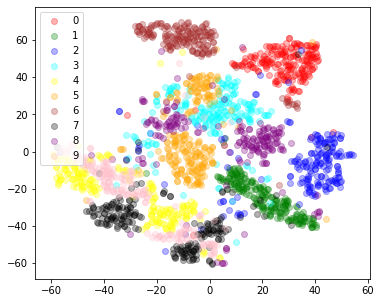

In [12]:
tsne(x_dev1[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, rowspace

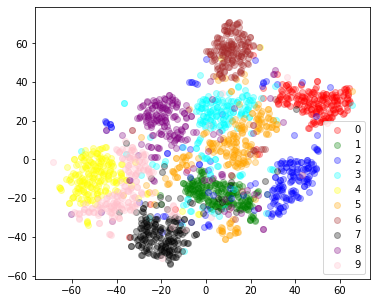

In [19]:
tsne(P_concat.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### Tsne by mnist digit identity, concat-rowspace

In [20]:
#tsne(P_concat.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### Tsne by mnist digit indentity, nullspace

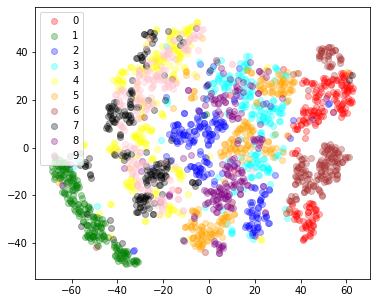

In [22]:
tsne(P.dot(x_dev1.T).T[:2000], ids_dev1[:2000])

### V measure

In [23]:
def compute_v_measure(vecs, labels_true, k=10):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k, random_state = 0)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        return sklearn.metrics.v_measure_score(labels_true, labels_pred)

k = 10 #len(set(data_for_tsen_deps.tolist()))
v_before = compute_v_measure(x_dev1[:5000], ids_dev1[:5000], k = k)
v_rowspace = compute_v_measure(P_rowspace.dot(x_dev1.T).T[:5000], ids_dev1[:5000], k = k)
v_nullspace = compute_v_measure(P.dot(x_dev1.T).T[:5000], ids_dev1[:5000], k = k)
print("V measure, original: {}\n V-measure, INLP-rowspace: {}\n V-measure, INLP-nullspace: {}".format(v_before, v_rowspace, v_nullspace))

V measure, original: 0.4891423735507664
 V-measure, INLP-rowspace: 0.6132517459862779
 V-measure, INLP-nullspace: 0.34645165715653575
